In [15]:
import pandas as pd

df = pd.read_excel("CCPP/Folds5x2_pp.xlsx")   # adjust if your path is different
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [16]:
print("Shape:", df.shape)
df.info()
df.describe()

Shape: (9568, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


In [17]:
before = len(df)
df = df.drop_duplicates()
after = len(df)
print("Duplicates removed:", before - after)

Duplicates removed: 41


In [18]:
df.isna().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

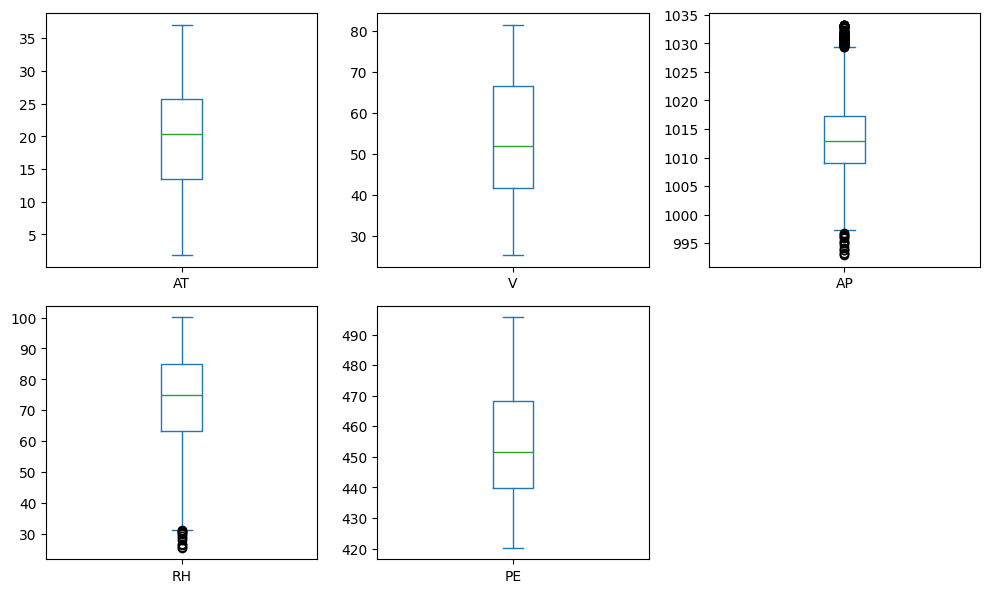

In [19]:
import matplotlib.pyplot as plt

cols = ["AT","V","AP","RH","PE"]
df[cols].plot(kind="box", subplots=True, layout=(2,3), figsize=(10,6), sharex=False)
plt.tight_layout()
plt.show()

In [20]:
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR

mask_outlier = (df[cols] < low) | (df[cols] > high)
print("Outlier rows:", mask_outlier.any(axis=1).sum())

df_clean = df[~mask_outlier.any(axis=1)].copy()
print("After outlier removal:", df_clean.shape)

Outlier rows: 104
After outlier removal: (9423, 5)


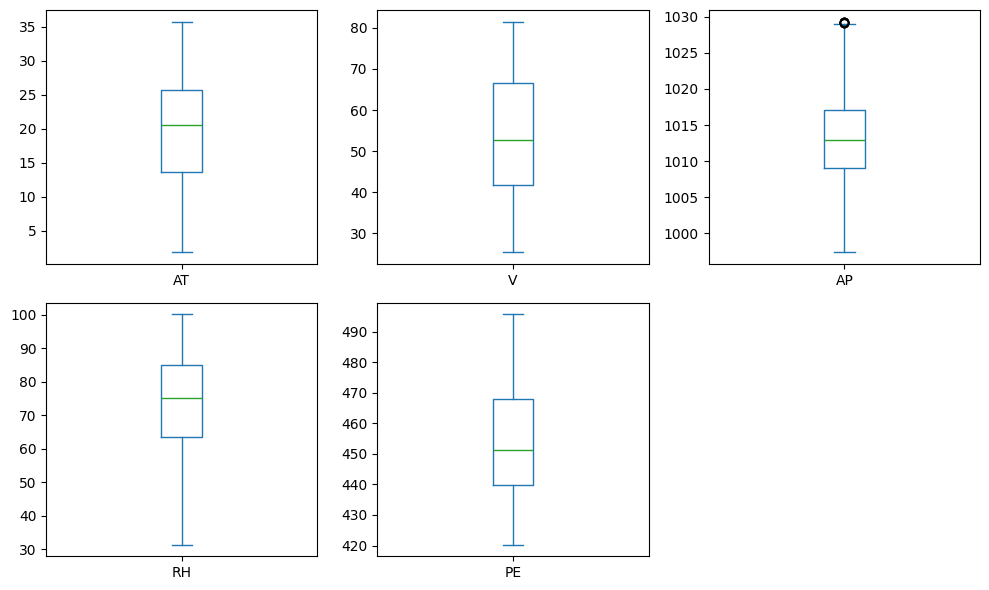

In [21]:
df_clean[cols].plot(kind="box", subplots=True, layout=(2,3), figsize=(10,6), sharex=False)
plt.tight_layout()
plt.show()

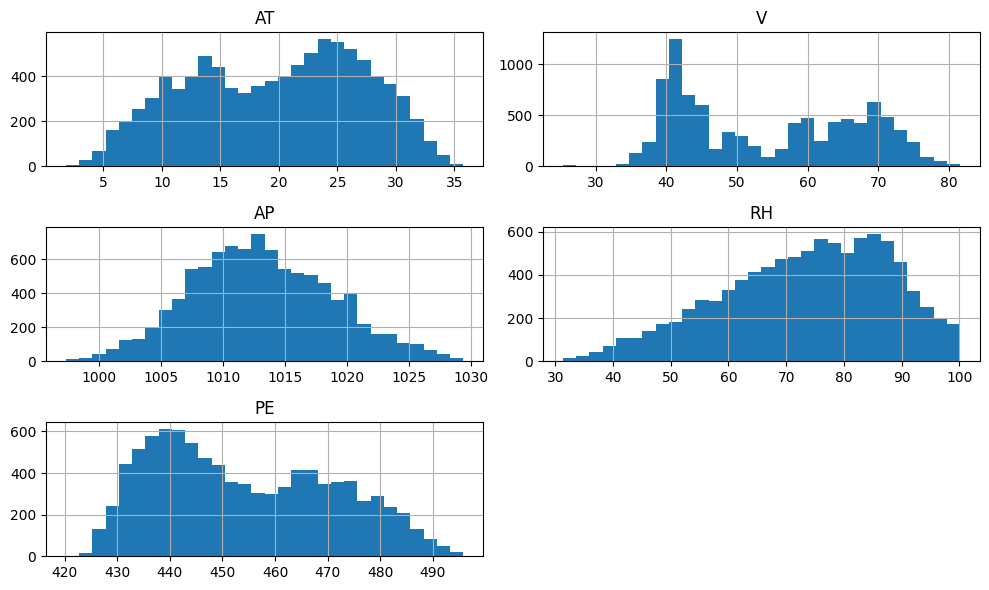

In [22]:
df_clean[cols].hist(bins=30, figsize=(10,6))
plt.tight_layout()
plt.show()

In [23]:
df_clean[cols].describe()

,AT,V,AP,RH,PE
count,9423.000000,9423.000000,9423.000000,9423.000000,9423.000000
mean,19.728498,54.404751,1013.125097,73.348106,454.174236
std,7.415999,12.678711,5.698357,14.552445,16.996007
min,1.810000,25.360000,997.340000,31.290000,420.260000
25%,13.610000,41.760000,1009.070000,63.325000,439.695000
50%,20.510000,52.720000,1012.880000,75.010000,451.200000
75%,25.760000,66.540000,1017.090000,84.850000,468.095000
max,35.770000,81.560000,1029.360000,100.160000,495.760000


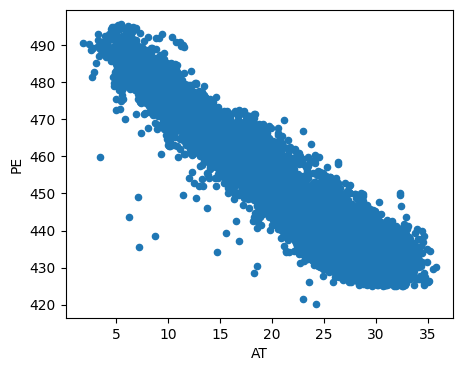

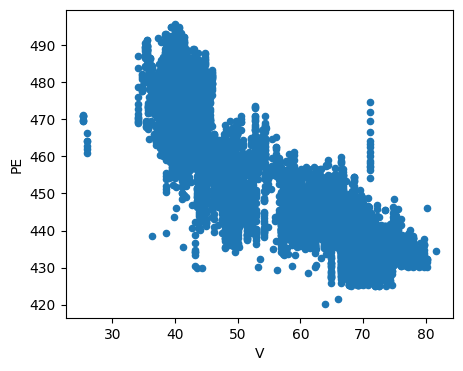

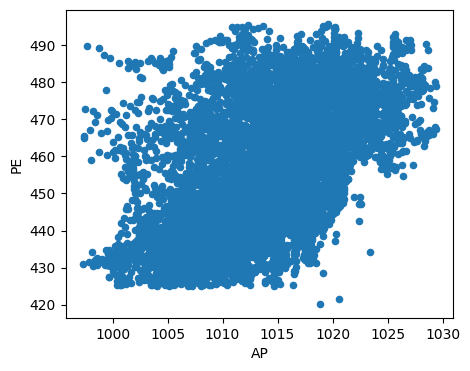

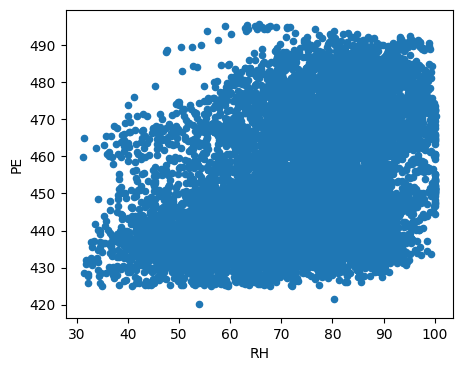

In [24]:
for x in ["AT","V","AP","RH"]:
    df_clean.plot.scatter(x=x, y="PE", figsize=(5,4))
    plt.show()

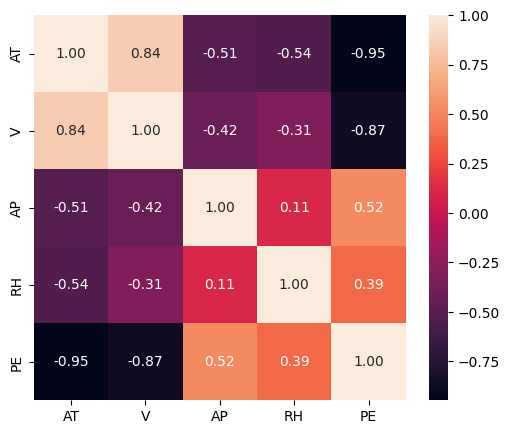

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_clean[cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

Week 2 Portfolio

Task 1: Create 3–5 balanced class labels for target

In [26]:
import pandas as pd

df_ml = df_clean.copy()

K = 4  # choose 3, 4, or 5
df_ml["PE_label"] = pd.qcut(df_ml["PE"], q=K, labels=False, duplicates="drop")

counts = df_ml["PE_label"].value_counts().sort_index()
print(counts)
print((counts / counts.sum()).round(3))

PE_label
0    2356
1    2356
2    2355
3    2356
Name: count, dtype: int64
PE_label
0    0.25
1    0.25
2    0.25
3    0.25
Name: count, dtype: float64


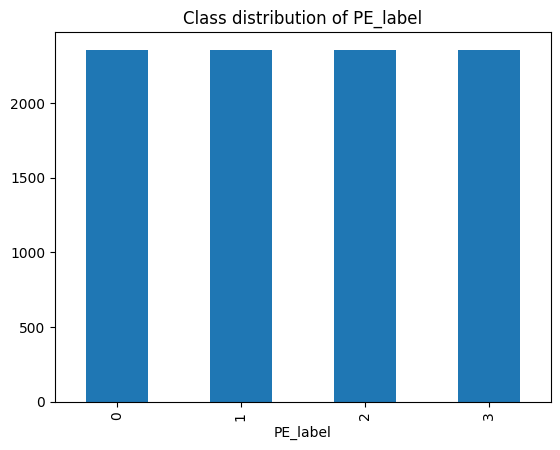

In [27]:
counts.plot(kind="bar", title="Class distribution of PE_label")
plt.show()

Task 2: All predictors are numeric; therefore only normalisation was required

Task 3: Feature engineering (based on EDA)

In [28]:
X = df_ml[["AT","V","AP","RH"]].copy()

X["AT2"] = X["AT"]**2
X["V2"] = X["V"]**2
X["ATxV"] = X["AT"] * X["V"]
X["APxRH"] = X["AP"] * X["RH"]

Task 4: 5 decision trees using 5 feature sets + comparison table

In [29]:
feature_sets = {
    "S1_raw_all": ["AT","V","AP","RH"],
    "S2_drop_weakest": ["AT","V","AP"],           # drop RH (usually weakest)
    "S3_top2": ["AT","V"],                        # strongest two
    "S4_raw_plus_engineered": ["AT","V","AP","RH","AT2","V2","ATxV","APxRH"],
    "S5_engineered_only": ["AT2","V2","ATxV","APxRH"],
}

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

y = df_ml["PE_label"]

def eval_feature_set(name, cols):
    X_use = X[cols]

    X_train, X_test, y_train, y_test = train_test_split(
        X_use, y, test_size=0.2, random_state=42, stratify=y
    )

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("dt", DecisionTreeClassifier(random_state=42))
    ])

    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    return {
        "Feature set": name,
        "Num features": len(cols),
        "Accuracy": accuracy_score(y_test, pred),
        "F1_macro": f1_score(y_test, pred, average="macro"),
    }

results = [eval_feature_set(name, cols) for name, cols in feature_sets.items()]
table = pd.DataFrame(results).sort_values(["F1_macro","Accuracy"], ascending=False)
table


,Feature set,Num features,Accuracy,F1_macro
1,S2_drop_weakest,3,0.816446,0.817042
3,S4_raw_plus_engineered,8,0.815915,0.816434
2,S3_top2,2,0.804244,0.804513
0,S1_raw_all,4,0.797878,0.797995
4,S5_engineered_only,4,0.797347,0.797834
